# ACO — Ant Colony Optimization for 1-D Bin Packing

Purpose: metaheuristic optimization to minimize the number of bins needed to pack items (OR-Library binpack*).

<ol> <li><b>Items:</b> integer sizes <code>w</code> of length <code>n</code></li> <li><b>Capacity:</b> bin capacity <code>C</code> (per instance)</li> <li><b>Objective:</b> minimize bins used <code>B</code> (tie-break by total unused space)</li> <li><b>Algorithm parameters:</b></li> <ol> <li><code>alpha (α)</code>: pheromone weight</li> <li><code>beta (β)</code>: heuristic weight</li> <li><code>rho (ρ)</code>: evaporation rate</li> <li><code>Q</code>: deposit strength</li> <li><code>ants</code>: solutions per iteration</li> <li><code>iters</code>: number of iterations</li> <li><code>seed</code>, <code>record_history</code></li> </ol> </ol>

1) Preprocessing and setup

Parse each OR-Library file → get (C, n, [opt_bins]) and the n sizes.

Show quick EDA (n, C, total weight, lower bound ≈ ceil(sum(w)/C); histogram of sizes).

Initialize pheromone vector tau (length n, one value per item).

Define heuristic eta per item (we use item size: larger items favored earlier).

2) Helper components

Decoder (tight-fit): given an item order, place each item into the fullest bin that can still accommodate it; otherwise open a new bin. Always feasible (load ≤ C).

Cost function: cost = (B, unused) where B = bins used and unused = total empty space across all bins.

3) Initialization

Set tau[i] = 1 for all items i.

Set global best to “infinite” cost; prepare history lists if needed.

4) Main ACO loop

For each iteration:

For each ant:

Build a permutation without replacement. At each step choose item j with probability proportional to tau[j]^alpha * eta[j]^beta.

Decode the permutation with tight-fit to get a feasible packing.

Evaluate cost = (B, unused) and keep the best ant of the iteration.

Pheromone update: evaporate tau ← (1 − rho) * tau, then deposit on items used by the iteration-best solution with Δ = Q / max(1, B).

Update global best and append to history.

5) Finish

Return best solution found (bins and loads), best cost (B, unused), convergence history, and runtime.

Build a results table over all instances:
Instance, n_items, Capacity, Best_bins, Unused_space, Runtime (s), opt_bins, gap_to_opt (and save CSV).

Notes

Higher beta → greedier (often faster early improvement).

Higher rho → more exploration (less stagnation).

More ants/iters → better solutions, longer runtime.

Using a per-item pheromone vector (instead of an n×n edge matrix) keeps memory low and matches the order-based decoder well.

## Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, math, time
from dataclasses import dataclass
from typing import List, Dict, Tuple
from IPython.display import display
from dataclasses import dataclass
import numpy as np, random, math



# file paths (download from https://people.brunel.ac.uk/~mastjjb/jeb/orlib/binpackinfo.html)
BINPACK1 = Path("./data/binpacking/binpack1.txt")
BINPACK2 = Path("./data/binpacking/binpack2.txt")
BINPACK3 = Path("./data/binpacking/binpack3.txt")
BINPACK4 = Path("./data/binpacking/binpack4.txt")
BINPACK5 = Path("./data/binpacking/binpack5.txt")
BINPACK6 = Path("./data/binpacking/binpack6.txt")
BINPACK7 = Path("./data/binpacking/binpack7.txt")
BINPACK8 = Path("./data/binpacking/binpack8.txt")

%matplotlib inline


In [2]:
all_paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
all_paths = [p for p in all_paths if p.exists()]  # keep only present files

In [3]:
def _read_int_tokens(path: Path) -> List[int]:
    toks = []
    with open(path, "r") as f:
        for t in f.read().split():
            try:
                toks.append(int(float(t)))
            except ValueError:
                pass
    return toks


def parse_binpack_all(path: Path) -> List[dict]:
    """
    Parse OR-Library 1D bin packing (binpack1...binpack8).
    Supports both C n [opt_bins] and n C headers.
    """
    toks = _read_int_tokens(path)
    p = 0
    if p >= len(toks):
        raise ValueError(f"{path} has no numeric tokens")

    I = int(toks[p]); p += 1
    out = []
    name_base = path.stem

    for k in range(1, I+1):
        if p + 1 >= len(toks):
            break

        C = int(toks[p]); n = int(toks[p+1])
        opt_bins = None

        def can_consume(pp, nn): return (pp + nn) <= len(toks)

        p_try = p + 2
        if p_try < len(toks) and can_consume(p_try+1, n):
            opt_bins = int(toks[p_try])
            p_hdr_end = p_try + 1
        else:
            p_hdr_end = p_try

        if can_consume(p_hdr_end, n):
            sizes = toks[p_hdr_end:p_hdr_end + n]
            if all(s <= C for s in sizes):
                p = p_hdr_end
            else:
                n = int(toks[p]); C = int(toks[p+1]); opt_bins = None
                p += 2
                sizes = toks[p:p+n]

        p += n
        out.append({
            "name": f"{name_base}#{k}",
            "capacity": C,
            "weights": list(map(int, sizes)),
            "opt_bins": opt_bins
        })

    return out


def parse_binpack_first(path: Path) -> dict:
    arr = parse_binpack_all(path)
    if not arr:
        raise ValueError(f"No instances parsed from {path}")
    return arr[0]


def instance_to_df(inst: dict) -> pd.DataFrame:
    df = pd.DataFrame({
        "Item": np.arange(1, len(inst["weights"]) + 1),
        "Size": inst["weights"]
    })
    df.attrs["capacity"] = inst["capacity"]
    df.attrs["name"] = inst["name"]
    df.attrs["opt_bins"] = inst.get("opt_bins")
    return df


def describe_instance(inst: dict):
    w = np.array(inst["weights"], dtype=int)
    C = int(inst["capacity"])
    lb = int(np.ceil(w.sum() / C))
    opt = inst.get("opt_bins")
    opt_txt = f", opt_bins={opt}" if opt else ""
    print(f"{inst['name']}: n={len(w)}, C={C}, total_weight={w.sum()}, lower_bound≈{lb}{opt_txt}")


In [4]:
def binpack_tables(top_n: int = 10) -> dict[str, pd.DataFrame]:
    """
    Load the first instance from each OR-Library binpack file that exists,
    print a short summary, and return them in a dict of DataFrames.
    """
    paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
    paths = [p for p in paths if p.exists()]

    datasets: dict[str, pd.DataFrame] = {}

    for p in paths:
        inst = parse_binpack_first(p)
        df = instance_to_df(inst)

        n = len(inst["weights"])
        C = inst["capacity"]
        lb = int(np.ceil(sum(inst["weights"]) / C))
        opt = inst.get("opt_bins")

        label = p.stem  # e.g., "binpack1"
        datasets[label] = df

        print(f"\n=== {label} ===")
        print(f"{df.attrs['name']}: n={n}, capacity={C}, lower_bound≈{lb}, opt_bins={opt}")
        print(df.head(top_n))

    return datasets

# Example usage
bp = binpack_tables(top_n=10)
bp[list(bp.keys())[0]].describe()



=== binpack1 ===
binpack1#1: n=120, capacity=150, lower_bound≈48, opt_bins=48
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack2 ===
binpack2#1: n=250, capacity=150, lower_bound≈99, opt_bins=99
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack3 ===
binpack3#1: n=500, capacity=150, lower_bound≈198, opt_bins=198
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack4 ===
binpack4#1: n=1000, capacity=150, lower_bound≈399, opt_bins=399
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack5 ===
binpack5#1: n=60, capacity=100, lower_bound≈2

,Item,Size
count,120.000000,120.000000
mean,60.500000,58.983333
std,34.785054,22.168940
min,1.000000,20.000000
25%,30.750000,41.000000
50%,60.500000,58.000000
75%,90.250000,79.000000
max,120.000000,98.000000


binpack1#1: n=120, C=150, total_weight=7078, lower_bound≈48, opt_bins=48


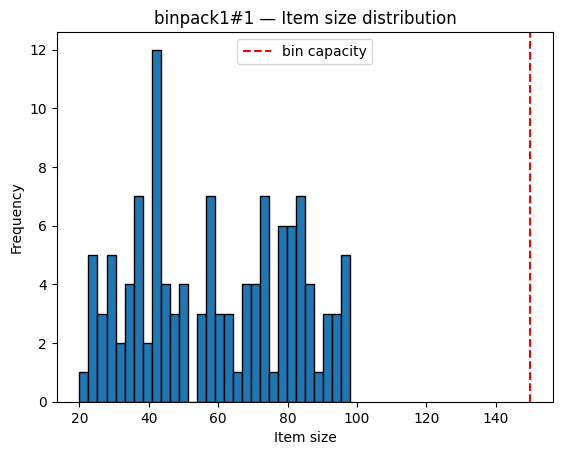

binpack2#1: n=250, C=150, total_weight=14783, lower_bound≈99, opt_bins=99


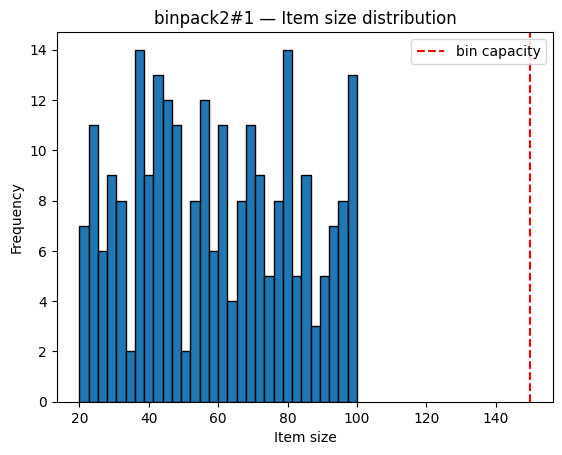

binpack3#1: n=500, C=150, total_weight=29637, lower_bound≈198, opt_bins=198


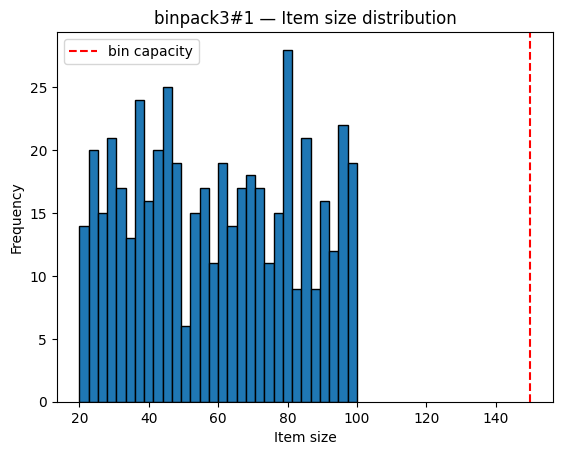

binpack4#1: n=1000, C=150, total_weight=59764, lower_bound≈399, opt_bins=399


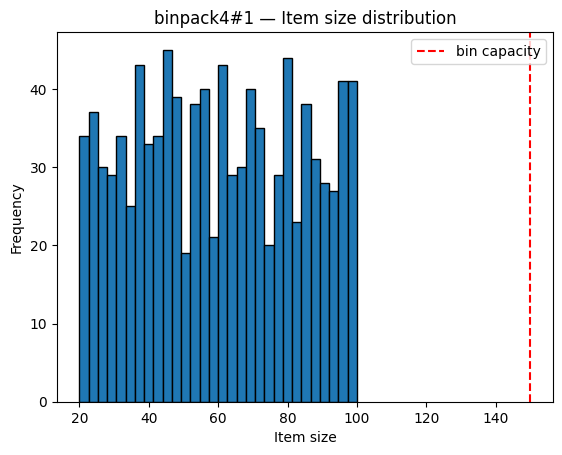

binpack5#1: n=60, C=100, total_weight=1975, lower_bound≈20, opt_bins=20


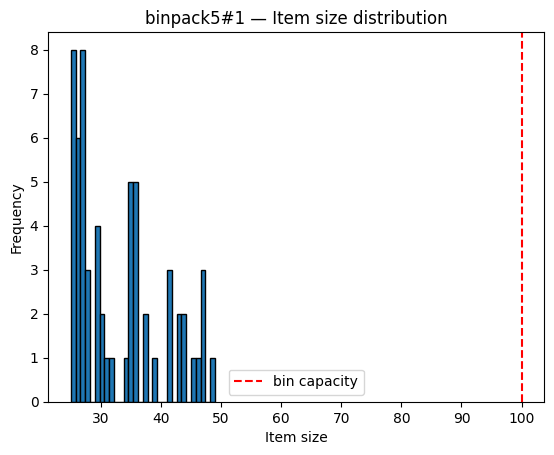

binpack6#1: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40


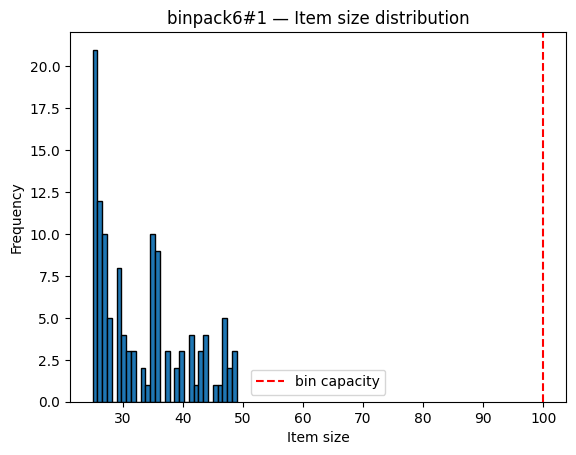

binpack7#1: n=249, C=100, total_weight=8200, lower_bound≈82, opt_bins=83


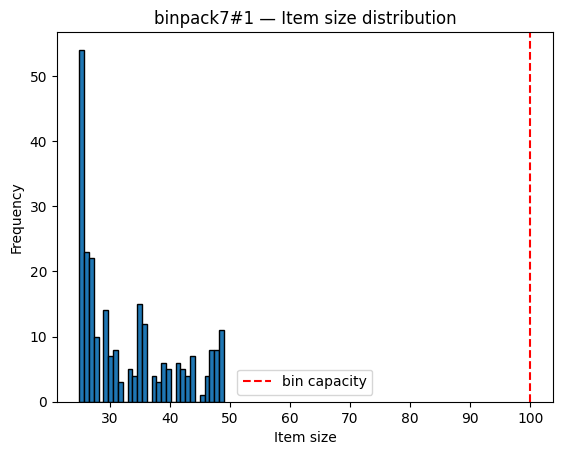

binpack8#1: n=501, C=100, total_weight=16487, lower_bound≈165, opt_bins=167


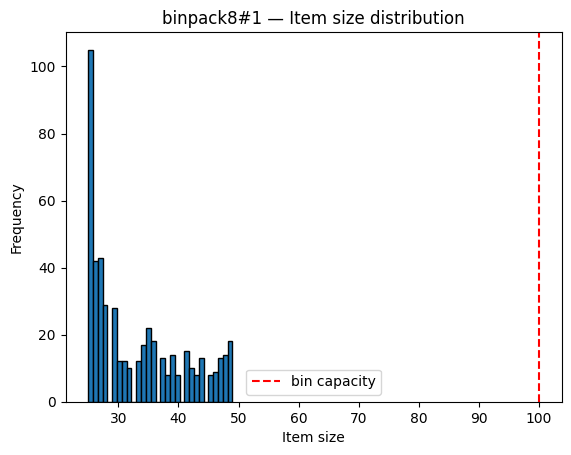

In [5]:
for path in [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]:
    inst = parse_binpack_first(path)
    describe_instance(inst)
    df = instance_to_df(inst)

    plt.figure()
    plt.hist(df["Size"], bins=30, edgecolor="black")
    plt.axvline(df.attrs["capacity"], color="red", linestyle="--", label="bin capacity")
    plt.title(f"{df.attrs['name']} — Item size distribution")
    plt.xlabel("Item size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [6]:
# params
@dataclass
class ACOParams:
    alpha: float = 1.0    # pheromone weight
    beta: float  = 2.0    # heuristic weight (favor bigger items)
    rho: float   = 0.15   # evaporation
    Q: float     = 10.0   # deposit strength
    ants: int    = 30     # solutions per iteration
    iters: int   = 200    # iterations
    seed: int    = 123    # reproducible
    record_history: bool = True

# tight-fit
def first_fit_tight(weights, capacity):
    bins, loads = [], []
    for w in weights:
        best_idx, best_slack = None, None
        for i, load in enumerate(loads):
            if load + w <= capacity:
                slack = capacity - (load + w)
                if best_slack is None or slack < best_slack:
                    best_slack, best_idx = slack, i
        if best_idx is None:
            bins.append([w]); loads.append(w)
        else:
            bins[best_idx].append(w); loads[best_idx] += w
    return bins, loads

def solution_cost(loads, capacity):
    B = len(loads)
    unused = B * capacity - sum(loads)
    return (B, unused)  # Ordering: minimize B, then unused

# ACO: pheromone per item (not per edge)
def aco_binpack(weights, capacity, p: ACOParams):
    random.seed(p.seed); np.random.seed(p.seed)
    W = np.asarray(weights, dtype=int)
    n = len(W)

    # pheromone per item, start uniform
    tau = np.ones(n, dtype=float)

    best_cost = (math.inf, math.inf)
    best_bins = best_loads = None
    history = []

    for _ in range(p.iters):
        it_best = (math.inf, math.inf)
        it_best_order = None
        it_best_bins = it_best_loads = None

        for _a in range(p.ants):
            # build a permutation by sampling without replacement
            remaining = list(range(n))
            order = []
            while remaining:
                # heuristic = item size (prefer larger first)
                eta = W[remaining].astype(float)

                # selection probabilities
                score = (tau[remaining] ** p.alpha) * (eta ** p.beta)
                probs = score / score.sum() if score.sum() else np.ones_like(score) / len(score)

                j = int(np.random.choice(remaining, p=probs))
                order.append(j)
                remaining.remove(j)

            perm = W[order]
            bins, loads = first_fit_tight(perm, capacity)
            cost = solution_cost(loads, capacity)
            if cost < it_best:
                it_best, it_best_order = cost, order
                it_best_bins, it_best_loads = bins, loads

        # evaporate & deposit (add same delta to all items in the best order)
        tau *= (1.0 - p.rho)
        tau[it_best_order] += p.Q / max(1, it_best[0])

        if it_best < best_cost:
            best_cost = it_best
            best_bins, best_loads = it_best_bins, it_best_loads

        if p.record_history:
            history.append(best_cost[0])

    return {
        "best_cost_bins": int(best_cost[0]),
        "unused_total": int(best_cost[1]),
        "best_bins": best_bins,
        "best_loads": best_loads,
        "history_bins": history,
    }


In [7]:
# Results table
params = ACOParams(ants=25, iters=200, rho=0.15, beta=2.0, seed=7)

rows = []
for path in all_paths:
    inst = parse_binpack_first(path)
    t0 = time.time()
    out = aco_binpack(inst["weights"], inst["capacity"], params)
    dt = time.time() - t0

    rows.append({
        "Instance": inst["name"],
        "n_items": len(inst["weights"]),
        "Capacity": inst["capacity"],
        "Best_bins": out["best_cost_bins"],
        "Unused_space": out["unused_total"],
        "Runtime (s)": round(dt, 2),
        "opt_bins": inst.get("opt_bins"),
    })

df_results = pd.DataFrame(rows)

# compare to known best
if "opt_bins" in df_results.columns:
    df_results["gap_to_opt"] = df_results["Best_bins"] - df_results["opt_bins"]   # how far solution is from the optimal

print("\n ACO Bin Packing Results")
display(df_results.sort_values("Instance").reset_index(drop=True))

# save
df_results.to_csv("ACO_binpacking_results.csv", index=False)



 ACO Bin Packing Results


,Instance,n_items,Capacity,Best_bins,Unused_space,Runtime (s),opt_bins,gap_to_opt
0,binpack1#1,120,150,49,272,23.34,48,1
1,binpack2#1,250,150,101,367,54.74,99,2
2,binpack3#1,500,150,203,813,203.35,198,5
3,binpack4#1,1000,150,409,1586,606.46,399,10
4,binpack5#1,60,100,21,125,6.27,20,1
5,binpack6#1,120,100,43,349,16.00,40,3
6,binpack7#1,249,100,90,800,51.98,83,7
7,binpack8#1,501,100,182,1713,181.61,167,15
